In [1]:
# Run in python console
import nltk; nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/monica/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [3]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 'RT', 'edu', 'use','refugee','afghan','https','co','Refugees','Refugee','refugees'])

In [4]:
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [5]:
# Import Dataset
df = pd.read_csv('file.csv','utf-8', skipinitialspace=True, delimiter=';',error_bad_lines=False,index_col=0)
print(df)
print(df.Tweet.unique())
#print(df)
df.head()

        No                                              Tweet  \
0        1  Registration Affiliate (Move River) on the Uni...   
1        2  #AusVisaXB4IranianRefugeesTR Hello World . Ple...   
2        3  #AusVisaXB4IranianRefugeesTR Hello World . Ple...   
3        4  #AusVisaXB4IranianRefugeesTR Hello World . Ple...   
4        5  #FreeBalochistan #UNhumanRights #hrc41 #HRC #C...   
...    ...                                                ...   
2344  2353  The #UN refugee agency on Friday said it would...   
2345  2354  The UN Refugee Agency's Chief mission @Prosopi...   
2346  2355  The Washington Post about to the latest report...   
2347  2356  UNHCR and partners seek US$296 million for Bur...   
2348  2357  UNHCR's Volker Türk explains the promise + pot...   

     Relevant/irrelevant Sentiment Intensity      Attitude  \
0             irrelevant   neutral       low       sharing   
1             irrelevant   neutral       low     unrelated   
2             irrelevant   neutra

,No,Tweet,Relevant/irrelevant,Sentiment,Intensity,Attitude,Link
0,1,Registration Affiliate (Move River) on the Uni...,irrelevant,neutral,low,sharing,http://twitter.com/MHPSSCollabora1/statuses/11...
1,2,#AusVisaXB4IranianRefugeesTR Hello World . Ple...,irrelevant,neutral,low,unrelated,http://twitter.com/MonashScholars/statuses/114...
2,3,#AusVisaXB4IranianRefugeesTR Hello World . Ple...,irrelevant,neutral,low,unrelated,http://twitter.com/IlkacaseDahir/statuses/1181...
3,4,#AusVisaXB4IranianRefugeesTR Hello World . Ple...,irrelevant,neutral,low,unrelated,http://twitter.com/SaddamH57747037/statuses/11...
4,5,#FreeBalochistan #UNhumanRights #hrc41 #HRC #C...,irrelevant,neutral,low,unrelated,http://twitter.com/EQL_Nationality/statuses/11...


In [6]:
# Convert to list

df['data'] = df.Tweet.values.tolist()

df['data'] = [re.sub('\s*@\s*\s?', ' ', str(sent)) for sent in df['data']]

df['data'] = [re.sub('\?', ' ', str(sent)) for sent in df['data']]

df['data'] = [re.sub('\_', ' ', str(sent)) for sent in df['data']]

df['data'] = [re.sub('@"[\d-]"', ' ', str(sent)) for sent in df['data']]

# Remove new line characters
df['data'] = [re.sub('\s+', ' ', str(sent)) for sent in df['data']]

# Remove distracting single quotes
df['data'] = [re.sub("\'", " ", str(sent)) for sent in df['data']]

df['data']=df['data'].str.lower()

df['data']=[re.sub(r"http\S+", " ", str(sent)) for sent in df['data']]
df['data'].unique()

array(['registration affiliate (move river) on the united countries top commissioner for refugees (unhcr)   ',
       '#ausvisaxb4iranianrefugeestr hello world . please hear #thevoice of our children. they need the attention of international community. #iranianrefugeesinturkey #resettlement4iranian #refugees #oscars2019 #resettlement refugees unhcrturkey🍁    ',
       '#ausvisaxb4iranianrefugeestr hello world . please hear #thevoice of our children. they need the attention of international community. #iranianrefugeesinturkey #resettlement4iranian #refugees #oscars2019 #resettlement refugees unhcrturkey🍁  ',
       ...,
       'qt askanshul: hindu newspaper drew our attention to put some mercy on these refugees i don t know on the basis of which ground.....we have many more enemies inside our country not outside.. ; 6 rohingyas caught by police for stealing copper wires worth rs 10 lakh from metro tracks & stations in delhi & noida. knives & a pistol have also been recovered. ironically

In [7]:
df['data'] = df['data'].apply(lambda x: [item for item in x.split() if item not in stop_words])


In [8]:
data= df['data']

In [9]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['registration', 'affiliate', 'move', 'river', 'united', 'countries', 'top', 'commissioner', 'unhcr']]


In [10]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['registration', 'affiliate', 'move', 'river', 'united', 'countries', 'top', 'commissioner', 'unhcr']


In [11]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [12]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['registration', 'affiliate']]


In [13]:
print(data_words_nostops)

[['registration', 'affiliate', 'move', 'river', 'united', 'countries', 'top', 'commissioner', 'unhcr'], ['ausvisaxb', 'hello', 'world', 'please', 'hear', 'thevoice', 'children', 'need', 'attention', 'international', 'community', 'resettlement', 'iranian', 'oscars', 'resettlement', 'unhcrturkey'], ['ausvisaxb', 'hello', 'world', 'please', 'hear', 'thevoice', 'children', 'need', 'attention', 'international', 'community', 'resettlement', 'iranian', 'oscars', 'resettlement', 'unhcrturkey'], ['ausvisaxb', 'hello', 'world', 'please', 'hear', 'thevoice', 'children', 'need', 'attention', 'international', 'community', 'resettlement', 'iranian', 'oscars', 'resettlement', 'unhcrturkey'], ['freebalochistan', 'unhumanrights', 'hrc', 'hrc', 'commissionerhr', 'statedlr', 'humanright', 'st', 'baloch', 'bhrorganization', 'bjp', 'india', 'pmoindia', 'humanity', 'humanityfirst', 'un', 'unhumanrights', 'icj', 'org'], ['kashmirbleeds', 'oxfordunion', 'muradsaeedpti', 'smqureshipti', 'tehminajanjua', 'india

In [14]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1)]]


In [15]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=80,
                                           alpha='auto',
                                           per_word_topics=True)

In [21]:
lda_model.show_topics(num_topics=5, num_words=10, formatted=False)

[(0,
  [('child', 0.040649045),
   ('today', 0.018533833),
   ('thank', 0.017016808),
   ('want', 0.013675048),
   ('give', 0.0129936375),
   ('make', 0.012274028),
   ('camp', 0.010927403),
   ('return', 0.009721421),
   ('good', 0.009227295),
   ('well', 0.007351697)]),
 (1,
  [('need', 0.021772414),
   ('statelessness', 0.019358464),
   ('stateless', 0.017516747),
   ('work', 0.0157417),
   ('ibelong', 0.015507217),
   ('say', 0.013587823),
   ('woman', 0.012121324),
   ('go', 0.010332842),
   ('take', 0.009781781),
   ('million', 0.009253999)]),
 (2,
  [('people', 0.058928113),
   ('support', 0.026298426),
   ('right', 0.018844657),
   ('live', 0.015479132),
   ('migrant', 0.013441309),
   ('family', 0.01244146),
   ('leave', 0.010392502),
   ('save', 0.009829623),
   ('new', 0.009650246),
   ('home', 0.009368912)]),
 (3,
  [('help', 0.048405956),
   ('resettlement', 0.038920116),
   ('world', 0.03867199),
   ('country', 0.03348441),
   ('year', 0.029114695),
   ('iraqi', 0.0243179

In [22]:
# Print the Keyword in the 10 topics
#pprint(lda_model.print_topics())
#doc_lda = lda_model[corpus]

In [23]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.548316066828462

Coherence Score:  0.3501576352963647


In [24]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.150309 -0.258390       1        1  29.306490
3     -0.310682 -0.035933       2        1  29.173058
2      0.102273  0.239390       3        1  23.666271
0      0.058099  0.054933       4        1  17.854176, topic_info=              Term        Freq       Total Category  logprob  loglift
174         people  320.000000  320.000000  Default  30.0000  30.0000
99            help  324.000000  324.000000  Default  29.0000  29.0000
104   resettlement  260.000000  260.000000  Default  28.0000  28.0000
4            world  259.000000  259.000000  Default  27.0000  27.0000
3            child  167.000000  167.000000  Default  26.0000  26.0000
...            ...         ...         ...      ...      ...      ...
994           show   16.038820   16.692585   Topic4  -5.5426   1.6830
772        african   14.297207   14.932217   Topic4  -5.6575   1.6795
2233         birth   14.688004   15.357658   Topic4  -5.6305   1.6783
514    persecution   15.691991   16.482681   Topic4  -5.5644   1.6738
102           make   50.264729   81.403641   Topic4  -4.4003   1.2408

[159 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1064      1  0.965320   action
772       4  0.937570  african
1755      4  0.955157      aid
825       1  0.981068     also
1167      4  0.970058    apply
...     ...       ...      ...
106       1  0.986799    woman
335       1  0.995940     work
4         2  0.998731    world
428       4  0.950377    would
167       2  0.998034     year

[134 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 3, 1])

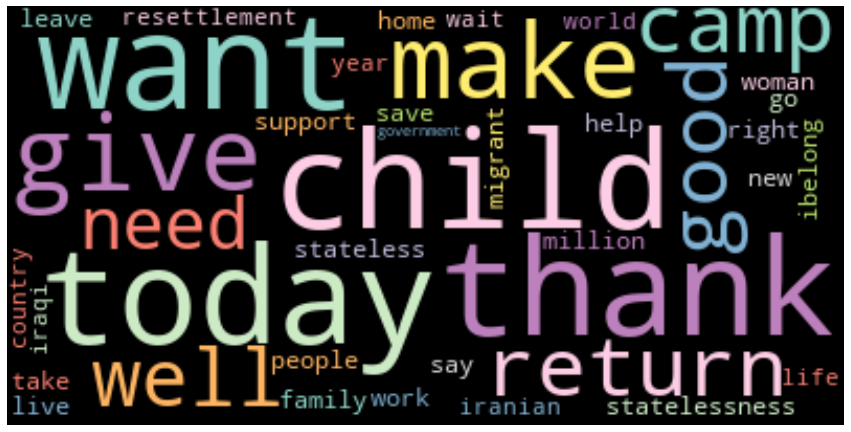

In [25]:
from wordcloud import WordCloud

from wordcloud import WordCloud, ImageColorGenerator
text = " ".join(str(each) for each in lda_model.print_topics())
wordcloud = WordCloud(max_words=200,colormap='Set3', collocations=False,background_color="black").generate(text)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='Bilinear')
plt.axis("off")
plt.figure(1,figsize=(12, 12))
plt.show()